# FYS4565: Example using the beamGeneratorLibrary

As discussed in the lectures, a particle can be represented as a vector of phase space coordinates.
Since we are in 3 dimensional space (horizontal, vertical, longitudinal), we need 6 dynamic variables to represent the particle state at any point in time.
There are several possibilities for how to do this, however in this course we will generally use $x$ [m], $x'$ [1], $y$ [m], $y'$ [1], $z$ [m], $E_k$ [eV], in that order.
Here the units are indicated in [square brackets], and a unit of [1] means the number is dimensionless.

Here $\{x, x'\}$ is the horizontal phase-space (position and angle relative to reference center of accelerator), $\{y, y'\}$ the vertical phase-space, and $\{z, E_k\}$ the longitudinal phase-space.
This is typically defined at a given location down the beam line $s$, which acts as the timelike coordinate of the system; it is also referenced to the on-momentum and on-axis particle with total momentum $p_0$.
The meaning of the position $z$ in the longitudinal phase-space is how far ahead (or behind, $z<0$) it is in front of of the reference particle (in the lab frame) at the given location $s$; it is essentially a measurement of time-of-arrival at the "measurement" location.
Please note that while $x'$ and $y'$ are often denominated in radians, to be fully accurate $x'=\frac{\mathrm{d}x}{\mathrm{d}s}$, while the angle is $\arctan(x')$, however we will work with small angles so the small angle approximation is valid.
Sometimes it is more conventient to work with the relative momentum offset of the particle $\Delta p / p_0$; this can be calculated from $E_k$.

In [1]:
## ... before we begin...

#Basic libraries
import numpy as np
import matplotlib.pyplot as plt

#Physics constants:
SI_e = 1.60217662e-19 #[C]
SI_c = 299792458      #[m/s]

m0_proton = 938.27e6  #[eV]

#Pretty-printing function
def printMatrixAll(M):
    for i in range(M.shape[0]):
        print(i,": ", end='')
        for j in range(M.shape[1]):
            print(f'{M[i,j]:10.3e} ',end='')
        print() #\n

## Beam description in Python

We can define particles one-by-one by hand as a vector $\vec p$ like:

In [2]:
x  = 10e-6   # [m]
xp = 0.1e-3  # [1]
y  = -5e-6   # [m]
yp = 0.5e-3  # [1]
z  = 1e-3    # [m]
Ek = 10.0e9 # [eV]

p = np.array([x,xp,y,yp,z,Ek])
print(p)

[ 1.e-05  1.e-04 -5.e-06  5.e-04  1.e-03  1.e+10]


For beams of $N$ particles, we will write them as a $6\times N$ matrix where each particle is one column:
$$
\mathbf{B} = 
\begin{pmatrix}
x_0 & x_1 & \cdots & x_N \\
x'_0 & x'_1 & \cdots & x'_N \\
y_0 & y_1 & \cdots & y_N \\
y'_0 & y'_1 & \cdots & y'_N \\
z_0 & z_1 & \cdots & z_N \\
Ek_0 & Ek_1 & \cdots & Ek_N
\end{pmatrix}
$$

Again this can be done by hand, however in practice we want to generate it from a statistical distribution, using a random number generator (RNG) 'dice'.
This is an algorithm that generates a sequence of pseudorandom numbers given an initial seed, i.e.:

[-0.45090128 -0.32936119  0.26234007 -1.51237121 -2.62601127  0.51326297
  0.2511026   0.56872457  0.34350875 -2.98366742  0.50602835  0.16517601
  0.77965737 -0.87238656  0.88427222  0.0785136   0.14010345  1.25400818
 -0.78512364 -0.24758362 -0.26491455 -0.37666703  1.69595502 -0.8793731
  0.37315175 -0.18890417  1.60466173  0.58530407  0.45439814 -2.26510915
  0.34639048 -0.30933968  1.5708483  -0.7091051   0.28598565 -0.11737405
 -0.90794718  0.77202083  1.19267895 -0.56887614  1.72649701  0.98480171
 -0.05321535 -0.44872168  0.17252754  0.68763287 -1.575959    0.16273249
 -1.37278136  1.08354527  1.22722293  1.07841539 -0.74030169 -0.55094471
 -0.22725809  0.5752043   0.89738538  0.22435214 -0.20609106  0.8665165
  0.47892487  1.98957519  0.72171703  1.42386884  0.54575902 -0.9114075
 -0.13879293  1.03884708  0.92047803  1.07461024  1.93491489  1.19232305
 -0.43908738 -0.34913327  1.5135973  -0.50741589 -0.82550579  0.69284484
  0.04496347 -1.28700367 -0.42058108  0.7058268  -1.66

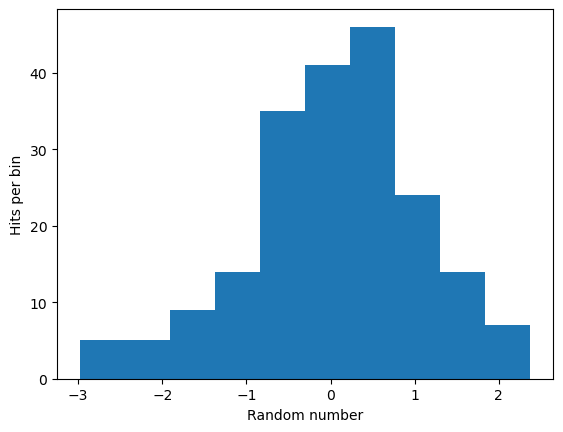

In [3]:
#Initialize a random number generator (RNG) 'dice'
RNG = np.random.default_rng()
#Generate 200 random numbers from Gaussian distribution (also known as "Normal Distribution" or "Bell curve")
r = RNG.normal(loc=0.0, scale=1.0, size=200)
print(r)

#Plot a histogram
plt.hist(r)
plt.xlabel('Random number')
plt.ylabel('Hits per bin')
plt.show()

For a 6D beam, we must specify the size of the beam in all 6 dimensions, as well as the correlations.
It is usually assumed that the beam is distributed according to a multivariate normal distribution.
We could thus specify the beam size directly by specifying the 6x6 covariance matrix.

In [4]:
#Size of beam distribution, energy and transversely

sigma_x = 3.855e-3 # [m] Horizontal beam size, set to give matched beta for FODO cell
sigma_y = 3.855e-3 # [m] Vertical   beam size, set to give matched beta for FODO cell

sigma_z = 5e-3;    # [m] Longitudinal bunch length
sigma_E_E = 0.001; # [-] Relative energy spread (dEk/Ek0)

It is however usually conventient to use the Twiss parameters for the transverse (horizontal and vertical) phase spaces, i.e. beta, alpha, and emittance.
The emittance is often given as an energy-normalized number which is invariant during acceleration; for this we first need to compute the relativistic parameters of the beam:

In [5]:
E0 = 938.27e6                   # [eV] particle rest mass (proton)
m0 = E0/2.998e8**2 * 1.602e-19; # [kg] particle rest mass
Ek0 = 10.0e9;                   # [eV] Kinetic energy of particles
gamma = (E0+Ek0)/E0             # [-]  Lorentz gamma factor

print(f'E0 = {E0/1e9} [GeV], m0 = {m0} [kg]')
print(f'Lorentz gamma = {gamma}')

E0 = 0.93827 [GeV], m0 = 1.6723496562751864e-27 [kg]
Lorentz gamma = 11.657912967482707


Then we can write down the Twiss parameters:

In [6]:
# Initial Twiss parameters
em_n_x = 1.0e-6;   # [m] Horizontal emittance NORMALIZED to energy
em_n_y = 1.0e-6;   # [m] Vertical   emittance NORMALIZED to energy

em_rms_x = em_n_x / gamma # [m] Horizontal geometrical emittance
em_rms_y = em_n_y / gamma # [m] Horizontal geometrical emittance

alpha_x = 0.0                    #[-]   Twiss horizontal alpha function (correlation), at a waist (alpha_x = -0.5*d(beta_x)/ds = 0)
beta_x = sigma_x**2 / em_rms_x     #[m]   Twiss horizontal beta function  (size)
gamma_x = (1+alpha_x**2)/beta_x  #[1/m] Twiss horizontal gamma function ()

print(f'beta_x = {beta_x} [m], gamma_x = {gamma_x} [1/m], alpha_x = {alpha_x} [-]')

alpha_y = 1.0                    #[-]   Twiss vertical alpha function, converging 
beta_y = sigma_y**2 / em_rms_y     #[m]   Twiss vertical beta function
gamma_y = (1+alpha_y**2)/beta_y  #[1/m] Twiss vertical gamma function

print(f'beta_y = {beta_y} [m], gamma_y = {gamma_y} [1/m], alpha_y = {alpha_y} [-]')

beta_x = 173.2485360575847 [m], gamma_x = 0.005772054545197531 [1/m], alpha_x = 0.0 [-]
beta_y = 173.2485360575847 [m], gamma_y = 0.011544109090395062 [1/m], alpha_y = 1.0 [-]


Finally we can generate a beam distribution using `rng.multivariate_normal(...)` by creating the covariance matrices:

In [7]:
# Define the beam distribution, one dimension at the time

N = 1000000; # number of simulated MACRO particles
#N=int(1e3)

# Horizontal phase space {x,x'}
#Must use GEOMETRIC emittance to generate distribution
em_rms_x = em_n_x/gamma                                                #[m] Horizontal geometric emittance
MU_x = np.array([0, 0])                                                #[m] Beam center position in x and x'
SIGMA_x = em_rms_x*np.array([[beta_x, -alpha_x],[-alpha_x, gamma_x]]) # Beam distribution covariance matrix
print("SIGMA_x =")
printMatrixAll(SIGMA_x)
#Sample particles from a multi-variate Gaussian distribution, [m, rad]
B_x = RNG.multivariate_normal(mean=MU_x, cov=SIGMA_x, size=N).T

# Vertical phase space {x,x'}
#Must use GEOMETRIC emittance to generate distribution
em_rms_y = em_n_y/gamma                                               #[m] Horizontal geometric emittance
MU_y = np.array([0, 0])                                               #[m] Beam center position in x and x'
SIGMA_y = em_rms_y*np.array([[beta_y, -alpha_y],[-alpha_y, gamma_y]]) # Beam distribution covariance matrix
print("SIGMA_y =")
printMatrixAll(SIGMA_y)
#Sample particles from a multi-variate Gaussian distribution
B_y = RNG.multivariate_normal(mean=MU_y, cov=SIGMA_y, size=N).T

# Longitudinal phase space {z,Ek}
z = sigma_z*RNG.normal(loc=0, scale=1, size=N)
Ek = Ek0*(1+sigma_E_E*RNG.normal(loc=0,scale=1,size=N))
B_z = np.vstack([z,Ek])

#Compose the total 6xN beam matrix, assuming no correlation between the three planes:
B = np.vstack([B_x, B_y, B_z])

print("First 10 particles:")

printMatrixAll(B[:,:10])


SIGMA_x =
0 :  1.486e-05 -0.000e+00 
1 : -0.000e+00  4.951e-10 
SIGMA_y =
0 :  1.486e-05 -8.578e-08 
1 : -8.578e-08  9.902e-10 


First 10 particles:
0 : -1.905e-03  1.675e-03  6.518e-03  1.277e-03 -1.378e-03 -2.297e-03 -2.515e-05 -5.466e-03  2.088e-03  1.541e-03 
1 :  6.358e-06 -1.955e-06 -4.083e-06 -3.778e-05  2.356e-05  2.885e-06 -1.186e-05 -2.048e-05  2.148e-05 -6.158e-06 
2 : -1.150e-04  2.730e-03 -3.213e-03  1.196e-02  1.324e-03 -5.806e-03  1.312e-03  4.524e-03  8.606e-03 -1.914e-03 
3 : -2.073e-05  8.409e-08 -6.167e-06 -5.582e-05 -4.086e-05  1.497e-06 -6.163e-06 -5.639e-05 -1.643e-05  1.215e-05 
4 :  2.092e-03 -1.135e-03 -2.297e-03  3.153e-03 -5.042e-03  1.228e-03 -1.148e-02 -3.591e-03 -3.512e-03  3.153e-03 
5 :  1.002e+10  1.001e+10  9.994e+09  1.000e+10  9.986e+09  1.001e+10  9.999e+09  9.995e+09  1.001e+10  9.992e+09 


In [8]:
print("Sample statistics:")

print(f"sigma_x   = {np.std(B[0,:])} [m]")
print(f"sigma_x'  = {np.std(B[1,:])} [rad]")
print(f"sigma_y   = {np.std(B[2,:])} [m]")
print(f"sigma_y'  = {np.std(B[3,:])} [rad]")
print(f"sigma_z   = {np.std(B[4,:])} [mm]")
print(f"sigma_E_k = {np.std(B[5,:]/1e9)} [GeV]")

covB = np.cov(B)

print(f"Covariance matrix =")
printMatrixAll(covB)

print(f"SQRT(ABS(Covariance matrix)) =")
printMatrixAll(np.sqrt(np.fabs(covB)))
      
 #     {}\n, sqrt(covB) =\n{np.sqrt(covB))}")

Sample statistics:
sigma_x   = 0.0038578198248901455 [m]
sigma_x'  = 2.224635270100676e-05 [rad]
sigma_y   = 0.0038578789205463344 [m]
sigma_y'  = 3.145072584228525e-05 [rad]
sigma_z   = 0.004998390719319836 [mm]
sigma_E_k = 0.010003141835890296 [GeV]
Covariance matrix =
0 :  1.488e-05  1.384e-10 -3.678e-09  3.060e-11  2.515e-08  3.057e+01 
1 :  1.384e-10  4.949e-10  7.133e-11 -7.227e-13 -4.007e-10 -9.875e-02 
2 : -3.678e-09  7.133e-11  1.488e-05 -8.582e-08  2.683e-08 -1.976e+00 
3 :  3.060e-11 -7.227e-13 -8.582e-08  9.891e-10  3.639e-11 -1.988e-01 
4 :  2.515e-08 -4.007e-10  2.683e-08  3.639e-11  2.498e-05  5.974e+01 
5 :  3.057e+01 -9.875e-02 -1.976e+00 -1.988e-01  5.974e+01  1.001e+14 
SQRT(ABS(Covariance matrix)) =
0 :  3.858e-03  1.176e-05  6.065e-05  5.532e-06  1.586e-04  5.529e+00 
1 :  1.176e-05  2.225e-05  8.446e-06  8.501e-07  2.002e-05  3.142e-01 
2 :  6.065e-05  8.446e-06  3.858e-03  2.929e-04  1.638e-04  1.406e+00 
3 :  5.532e-06  8.501e-07  2.929e-04  3.145e-05  6.032e-06

Please note that the diagonal entries of the square root of the sample covariance matrix is equal to the sigmas.
We also note that the first two diagonal 2x2 sub blocks of the sample covariance matrix are very close to the `SIGMA_x` and `SIGMA_y` 2x2 matrices used to generate the single-plane particle arrays `B_x` and `B_y`.

## Beam generation with BeamGenerator library


It is convenient to put the code for generating the particle arrays into a function, and putting this function into a module (a `.py` file).
This is done with `beamGeneratorLibrary.py`, which should be located in the same folder as this notebook.
The file comes from the GitHub repository: https://github.com/AcceleratorPhysicsUiO/FYS4565-codelibrary

Having such a file makes it easy to re-use common functionality between tasks organized into notebooks, and reduces the risk of mistakes.

In [9]:
#Load the Python module
import beamGeneratorLibrary

In [10]:
#Generate a beam, using the already-initialized RNG
B_gen = beamGeneratorLibrary.generateBeam(N,beta_x,alpha_x,em_rms_x,beta_y,alpha_y,em_rms_y,sigma_E_E,sigma_z,Ek0, rng=RNG)

print("Sample statistics:")

print(f"sigma_x   = {np.std(B_gen[0,:])} [m]")
print(f"sigma_x'  = {np.std(B_gen[1,:])} [rad]")
print(f"sigma_y   = {np.std(B_gen[2,:])} [m]")
print(f"sigma_y'  = {np.std(B_gen[3,:])} [rad]")
print(f"sigma_z   = {np.std(B_gen[4,:])} [mm]")
print(f"sigma_E_k = {np.std(B_gen[5,:]/1e9)} [GeV]")

covB_gen = np.cov(B_gen)

print(f"Covariance matrix =")
printMatrixAll(covB_gen)

print(f"SQRT(ABS(Covariance matrix)) =")
printMatrixAll(np.sqrt(np.fabs(covB_gen)))

Sample statistics:
sigma_x   = 0.0038550097430657265 [m]
sigma_x'  = 2.224349317814639e-05 [rad]
sigma_y   = 0.003853209731511965 [m]
sigma_y'  = 3.1446658167838776e-05 [rad]
sigma_z   = 0.004998551652458933 [mm]
sigma_E_k = 1.0000663944574524e-12 [GeV]
Covariance matrix =
0 :  1.486e-05  1.112e-12  9.622e-09 -6.676e-11 -2.848e-08 -1.754e-09 
1 :  1.112e-12  4.948e-10  6.509e-11 -8.728e-14  1.932e-10 -6.116e-12 
2 :  9.622e-09  6.509e-11  1.485e-05 -8.561e-08 -1.814e-08  7.493e-10 
3 : -6.676e-11 -8.728e-14 -8.561e-08  9.889e-10  1.267e-11  3.089e-13 
4 : -2.848e-08  1.932e-10 -1.814e-08  1.267e-11  2.499e-05  1.160e-09 
5 : -1.754e-09 -6.116e-12  7.493e-10  3.089e-13  1.160e-09  1.000e-06 
SQRT(ABS(Covariance matrix)) =
0 :  3.855e-03  1.055e-06  9.809e-05  8.171e-06  1.688e-04  4.188e-05 
1 :  1.055e-06  2.224e-05  8.068e-06  2.954e-07  1.390e-05  2.473e-06 
2 :  9.809e-05  8.068e-06  3.853e-03  2.926e-04  1.347e-04  2.737e-05 
3 :  8.171e-06  2.954e-07  2.926e-04  3.145e-05  3.559e-

## Visualize a 6D beam

In [11]:
from matplotlib import pyplot as plt

In [12]:
#Helper function to plot 2D histograms

def plotDensity(X,XP,bins=10,label="X"):
    """Plot the particle distribution as a 2D density plot using a histogram.
    Also makes a new figure and adds axis titles etc.
    Set 'bins' argument to specify number of bins, as in matplotlib.pyplot.hist2d()
    """
    
    plt.figure()
    
    plt.hist2d(X*1e3,XP*1e6,bins=bins)
    plt.colorbar(label='Macroparticles / bin')
    
    plt.xlabel(label+" [mm]")
    plt.ylabel(label+"' [urad]")

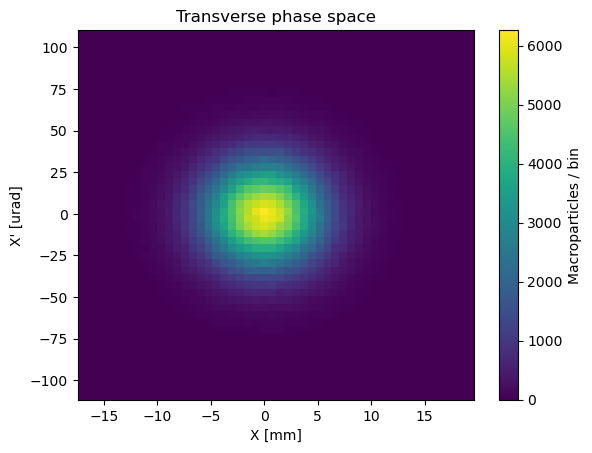

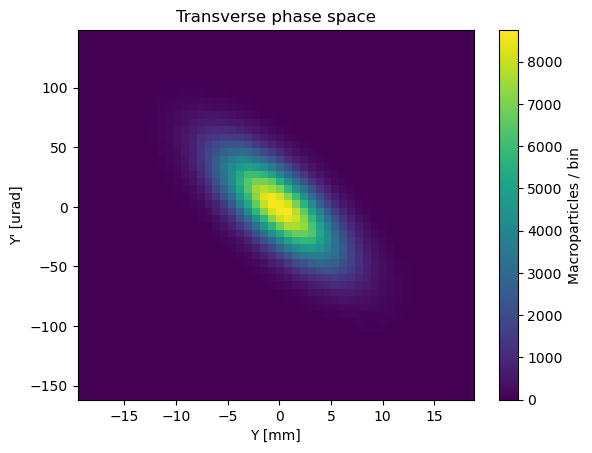

In [13]:
plotDensity(B[0,:],B[1,:], bins=50)
plt.title('Transverse phase space')

plotDensity(B[2,:],B[3,:], bins=50, label='Y')
plt.title('Transverse phase space')

plt.show()

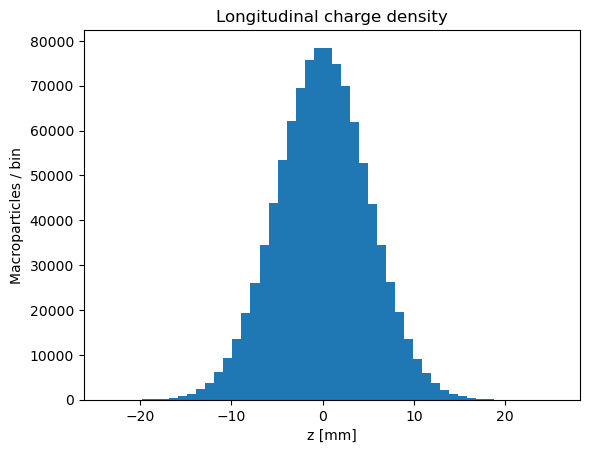

In [14]:
plt.figure()

plt.hist(B[4,:]*1e3,bins=50)

plt.title('Longitudinal charge density')
plt.xlabel('z [mm]')
plt.ylabel('Macroparticles / bin')
plt.show()

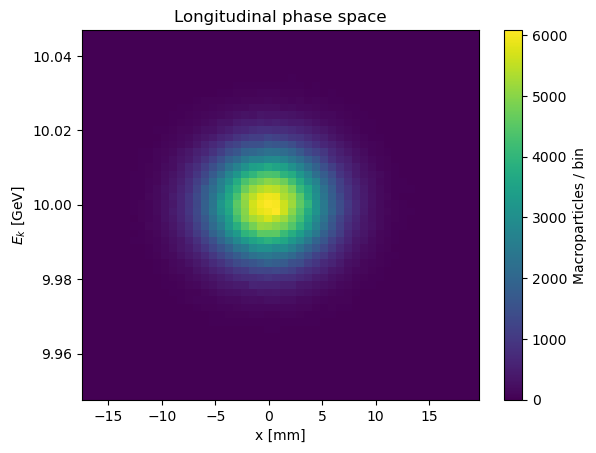

In [15]:
plt.figure()

plt.hist2d(B[0,:]*1e3,B[5,:]/1e9,bins=50)
plt.colorbar(label='Macroparticles / bin')

plt.title('Longitudinal phase space')
plt.xlabel("x [mm]")
plt.ylabel("$E_k$ [GeV]")

plt.show()

In [16]:
import mpl_toolkits.mplot3d
#Uncomment next line to popup plots, for rotateable 3D plot
# %matplotlib qt

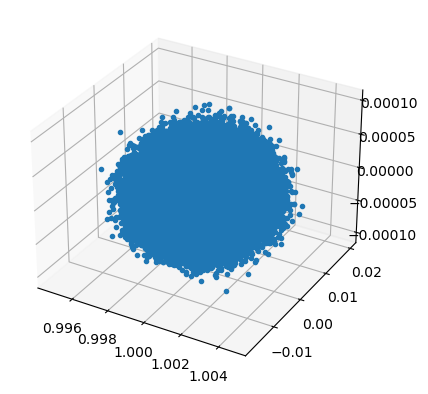

In [17]:
# 3D plot. Note that this implementation may not work on all OS.
fig=plt.figure()
#ax=mpl_toolkits.mplot3d.Axes3D(fig)
ax = plt.axes(projection ='3d')
ax.plot3D(B[5,:],B[0,:],B[1,:], '.')
plt.show()